100%|██████████| 799/799 [00:00<00:00, 1487.83it/s]


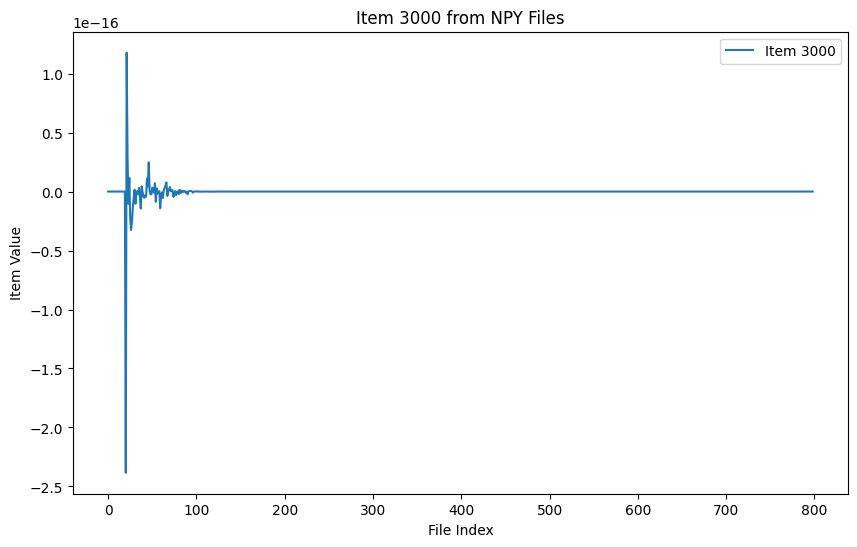

In [1]:
import matplotlib.pyplot as plt
from tqdm import trange
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np


# Assuming the npy files are named 'delta_0.npy', 'delta_1.npy', etc.

start_n = 0
end_n = 799

# Specify the index of the item to plot
item_index = 3000

# Initialize a list to store the item values
item_values = []
vector_values = []

# Load the item values from the npy files
for i in trange(start_n, end_n):
    vector = np.load(f'/user/as6154/dissert/L12_half_data/delta_{i}.npy')

    item_values.append(vector[item_index])
    vector_values.append(vector)

vector_values = np.array(vector_values)
# Plot the item values
plt.figure(figsize=(10, 6))
plt.plot(item_values, label=f'Item {item_index}')

plt.xlabel('File Index')
plt.ylabel('Item Value')
plt.title(f'Item {item_index} from NPY Files')
plt.legend()
plt.show()

In [2]:
len(vector)

4096

In [3]:
import pickle

# dir_path = "/user/as6154/dissert/szhalf_L12_delta_-2_to_0_interval_400_secondDelta_1_to_1_interval_1_data"
dir_path = "/shared/share_mala/andrew/diss/szhalf_L12_delta_-2_to_2_interval_4000_secondDelta_1_to_1_interval_1_data"

# Define the path to save the pickle file
pickle_file_path = f'{dir_path}/10000_binned_values.pkl'
with open(pickle_file_path, 'rb') as f:
    binned_values_loaded = pickle.load(f)

print(f"Binned values loaded from pickle file (first 10): {binned_values_loaded[:10]}")

Binned values loaded from pickle file (first 10): [array([10000,  3218,  3218, ...,  3218,  3218,  3218]), array([10000,  3218,  3218, ...,  3218,  3218,  3218]), array([10000,  3218,  3218, ...,  3218,  3218,  3218]), array([10000,  3218,  3218, ...,  3218,  3218,  3218]), array([10000,  3218,  3218, ...,  3218,  3218,  3218]), array([10000,  3218,  3218, ...,  3218,  3218,  3218]), array([10000,  3218,  3218, ...,  3218,  3218,  3218]), array([10000,  3218,  3218, ...,  3218,  3218,  3218]), array([10000,  3218,  3218, ...,  3218,  3218,  3218]), array([10000,  3218,  3218, ...,  3218,  3218,  3218])]


In [11]:
sequence_length = 10
batch_size = 10

class HighDimensionalDataset(Dataset):
    def __init__(self, data, n_items = 1000, random = False):
        self.data = data
        self.random = random
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.random:
            start_index = np.random.randint(0, len(self.data) - sequence_length)
        else:
            start_index = min(idx, len(self.data) - sequence_length)
        sequence = self.data[start_index : start_index + sequence_length]
        return torch.tensor(sequence, dtype=torch.float32)

# Split the data into training and testing sets
train_data = binned_values_loaded
test_data = binned_values_loaded

# TODO: But this test_dataset would also work if it's overfitting?
train_dataset = HighDimensionalDataset(train_data, random = True)
test_dataset = HighDimensionalDataset(test_data, random = False)


# Create dataloaders for training and testing
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [12]:
train_dataset[100].shape

torch.Size([10, 4096])

Setting:

1. We have a sequence 800 data, that is across delta changing, each item is vector dim 4096.
2. I want to predict next data, conditioning on previous data. 
3. So my input and output is dim 4096. 

Idea is to 


-----

Normal language models take in batch of text, text is in high dimension, but it's a number alone.
so it's BxN.

Our's is BxNxD.

So i need to embed the D to 1D?


Can we embed continous instead of quantize? 
- but we need to tokenize first right?
- unless i train my own tokenizer with bpe?
- so we shouldnt?

In [13]:
train_dataset[0].shape[1]

4096

In [14]:
# Garg inspired model
from transformers import GPT2Config, GPT2Model
import torch.nn as nn


class Transformer(nn.Module):
    def __init__(self, n_dims, n_positions, n_embd=4096, n_layer=12, n_head=4):
        super(Transformer, self).__init__()
        configuration = GPT2Config(
            n_positions=2 * n_positions,
            n_embd=n_embd,
            n_layer=n_layer,
            n_head=n_head,
            resid_pdrop=0.0,
            embd_pdrop=0.0,
            attn_pdrop=0.0,
            use_cache=False,
        )
        self.name = f"gpt2_embd={n_embd}_layer={n_layer}_head={n_head}"

        self.n_positions = n_positions
        self.n_dims = n_dims
        self._read_in = nn.Linear(n_dims, n_embd)
        self._backbone = GPT2Model(configuration)
        self._read_out = nn.Linear(n_embd, n_dims)

    def forward(self, x):
        embeds = self._read_in(x)
        output = self._backbone(inputs_embeds = embeds).last_hidden_state
        prediction = self._read_out(output)
        return prediction
    
n_dims = train_dataset[0].shape[1]
n_positions = 256

model = Transformer(n_dims, n_positions)

input_data = torch.randn(batch_size, sequence_length, n_dims)

output = model(input_data)
print(output.shape)

torch.Size([10, 10, 4096])


In [15]:
next(iter(train_dataloader)).shape

torch.Size([10, 10, 4096])

In [16]:
next(iter(test_dataloader)).shape

torch.Size([1, 10, 4096])

In [17]:
import wandb
from transformers import AdamW, get_linear_schedule_with_warmup
import pandas as pd


wandb.init(project="GPT_QFT")
loss_fn = nn.MSELoss()
device = "cuda:0"
num_epochs = 100
eval_steps = 100

optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-4)

# optimizer = AdamW(model.parameters(), lr=1e-4)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=100, num_training_steps=len(train_dataloader) * num_epochs)

def evaluate_model(model, test_dataloader, device, loss_fn):
    from datetime import datetime

    current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")
    loss_data_csv_fp = f"loss_data/{current_datetime}.csv"
    loss_df = pd.DataFrame()
    model.eval()
    with torch.no_grad():
        loss_array = []
        for i, (test_input_seq) in enumerate(test_dataloader):
            test_target_seq = test_input_seq[:, -1:, :]
            test_input_seq = test_input_seq.to(device)
            test_target_seq = test_target_seq.to(device)

            test_output = model(test_input_seq)
            test_output = test_output[:, -1:, :]

            test_loss = loss_fn(test_output, test_target_seq)
            loss_array.append((i, test_loss.item()))
        loss_df = pd.DataFrame([loss for _, loss in loss_array], columns=['Loss']).transpose()
        loss_df.to_csv(loss_data_csv_fp, mode='a', header=False, index=False)

        loss_array.sort(key=lambda x: x[1], reverse=True)
        print(f'Highest Loss at index: {loss_array[0][0]}, Loss: {loss_array[0][1]}')
        print(f'Lowest Loss at index: {loss_array[-1][0]}, Loss: {loss_array[-1][1]}')
        wandb.log({"Highest Loss Index": loss_array[0][0], "Lowest Loss Index": loss_array[-1][0]})
    model.train()

for epoch in trange(num_epochs):
    for i, (input_seq) in enumerate(train_dataloader):

        target_seq = input_seq[:, 1:, :]

        model.to(device)
        input_seq = input_seq.to(device)
        target_seq = target_seq.to(device)
        output = model(input_seq)
        output = output[:, 1:, :]

        loss = loss_fn(output, target_seq)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        if (i+1) % eval_steps == 0:
            evaluate_model(model, test_dataloader, device, loss_fn)
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_dataloader)}], Loss: {loss.item()}')
            wandb.log({"Loss": loss.item()})

  0%|          | 0/100 [00:01<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 192.00 MiB. GPU 